## Weight & Biases
Zur Nachverfolgung und Analyse der Model-Performance

### Dataset & Runs
Namen für Datensets und Runs für bessere Nachvollziehbarkeit auf wandb

#### Runs
- **gb-hnf-uc**: Gradient Boosting mit HNF & UsageCluster
- **gb-hnf-cu**: Gradient Boosting mit HNF & Combined Usage


### Gradient Boosting
Imports & Datensatz laden

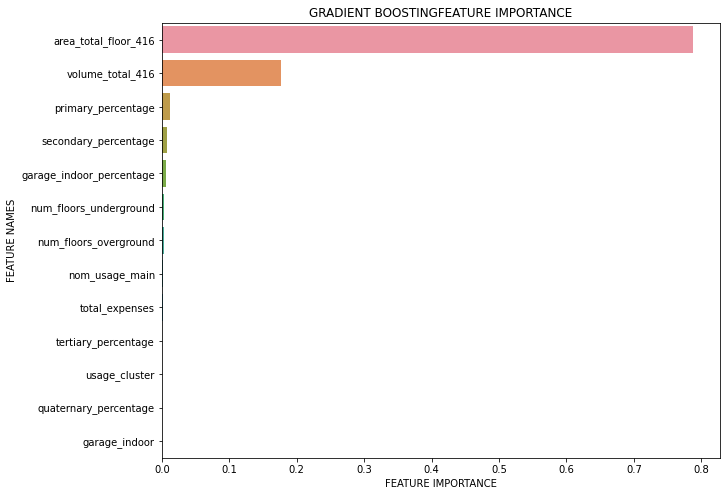

In [1]:
from typing import Final
import wandb
from numpy import mean
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import src.package.charts as charts
import src.package.importer as im
import src.package.importer_usages as imp_usg
import src.package.ml_helper as ml_helper

# load dataset
df = im.get_dataset('../package/datasets/train_set.csv')
df = imp_usg.extract_usage_details(df)
df = imp_usg.extract_garage_details(df)

X, y = ml_helper.hnf_dataset_full(df)

wandb.login()


TAG_TRAIN_SET: Final = 'train-set'
TAG_TEST_SET: Final = 'test-set'
config = {
     'model': 'LinearRegression',
     'features': ', '.join(X.columns.values),
     'dataset-count': len(X.index),
     'description': 'Drop all, Default Hyperparameter'
}
wandb.init(project='Metriken Bauwesen', entity='devcore', config=config, tags=[TAG_TRAIN_SET])

# train and evaluate model
regr = GradientBoostingRegressor(random_state=0)
# regr = linear_model.LinearRegression()
scores_map = ml_helper.cross_validation(regr, X, y)

# log result of cross validation to wandb
for key in scores_map.keys():
    if key in {'fit_time', 'score_time'}:
        continue
    scores = scores_map[key]
    wandb.log({f'{key}_mean': mean(scores)})
    print({f'{key}_mean': mean(scores)})

# use wandb regression eval
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regr.fit(X_train, y_train)
wandb.sklearn.plot_regressor(regr, X_train, X_test, y_train, y_test, model_name='Gradient Boost')

charts.plot_feature_importance(regr.feature_importances_, X.columns, 'GRADIENT BOOSTING')
